In [4]:
%load_ext autoreload
%autoreload 2
import os, re

import discovery as ds
# import PTMCMCSampler

from tqdm import tqdm

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as pp

import jax
import jax.numpy as jnp
import glob
import matplotlib.pyplot as plt
from scipy.special import logsumexp
import numpyro
from numpyro import distributions as dist, infer
from numpyro.handlers import reparam
from numpyro.infer.reparam import LocScaleReparam
plt.style.use("/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/Notes/cross_validation/meyers_latex.mplstyle")
import sys
sys.path.append("../modules")
import models as lncass_models
from lncass import PRIOR_DICT, setup_javier_sampling_method
from jax.scipy.optimize import minimize

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# psrname = 'J1643-1224'
psrname = 'J1909-3744'
maindir = '/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/pulsar_discovery/main_fork/discovery'
psrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob(f'{maindir}/data/*-[JB]*.feather'))]
Tspan_pta = ds.getspan(psrs)
print(Tspan_pta / 365.25 / 86400)
names = [psr.name for psr in psrs]
idx = names.index(psrname)
psr = psrs[idx]
Tspan_psr = ds.getspan([psr])
n_rn_freqs = 30

16.029777268872294


In [108]:
alphas, uvals, heights = setup_javier_sampling_method(20)

/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/flexible_pta_spectral_models/notebooks/../modules/lncass.py:55: RuntimeWarning: invalid value encountered in scalar divide
  return beta


(array([  9.,   7.,  11.,   5.,  16., 912.,   3.,   9.,   6.,  11.,  11.]),
 array([-19.93255816, -16.36601151, -12.79946486,  -9.2329182 ,
         -5.66637155,  -2.0998249 ,   1.46672175,   5.0332684 ,
          8.59981505,  12.1663617 ,  15.73290835,  19.299455  ]),
 <BarContainer object of 11 artists>)

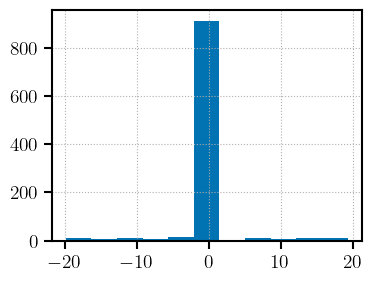

In [109]:
from scipy.interpolate import RegularGridInterpolator
X, Y = np.meshgrid(alphas, uvals)
beta_func = RegularGridInterpolator((np.array(alphas), np.array(uvals)), np.array(heights).T)

u_tests = np.random.uniform(0, 1, 1000)
alpha_tests = 0.1 * np.ones(1000)
pat = beta_func((alpha_tests, u_tests))
plt.hist(pat, bins='auto')

(array([ 10.,  10.,  10.,  10.,  10., 110.,  10.,  10.,  10.,  10.]),
 array([-20., -16., -12.,  -8.,  -4.,   0.,   4.,   8.,  12.,  16.,  20.]),
 <BarContainer object of 10 artists>)

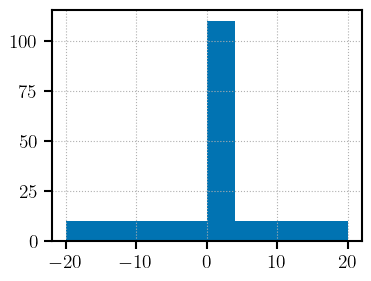

In [110]:
plt.hist(heights[:, 99])

In [101]:
def u_to_beta(u, alpha):
    if u == 0:
        beta = 1
    elif u <= alpha / 2:
        beta = 1 - u  / alpha
    elif u > alpha / 2 and u < (1-(alpha / 2)):
        beta = 0.5
    elif u >= (1 - (alpha / 2)):
        beta = (1 - u) / alpha
    return beta

/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/flexible_pta_spectral_models/notebooks/../modules/lncass.py:55: RuntimeWarning: invalid value encountered in scalar divide
  return beta


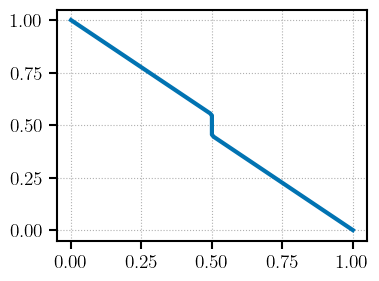

In [107]:
plt.plot([u_to_beta(kk, 0.9) for kk in np.linspace(0, 1, 100)], np.linspace(0, 1, 100))

In [3]:
# for injection purposes
psrl = ds.PulsarLikelihood([psr.residuals,
                        ds.makenoise_measurement(psr, psr.noisedict),
                        ds.makegp_ecorr(psr, psr.noisedict),
                        ds.makegp_timing(psr, variance=1e-19),
                        ds.makegp_fourier(psr, ds.freespectrum, n_rn_freqs, T=Tspan_psr, name='red_noise')])

In [4]:
psrl.logL.params

['J1909-3744_red_noise_log10_rho(30)']

In [111]:
residuals = psrl.sample(jax.random.PRNGKey(101), {'J1909-3744_red_noise_log10_rho(30)': injection})
print(residuals[1])

NameError: name 'psrl' is not defined

In [112]:
psr.residuals = np.array(residuals[1])

NameError: name 'residuals' is not defined

<ErrorbarContainer object of 3 artists>

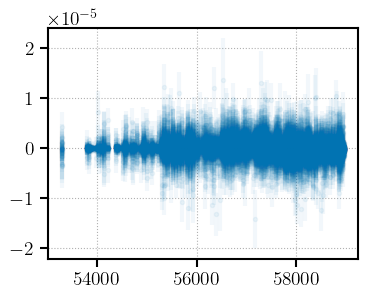

In [113]:
plt.errorbar(psr.toas / 86400, psr.residuals, yerr=psr.toaerrs, fmt='.', alpha=0.05)

In [117]:
model, gl = lncass_models.create_rn_single_psr_model_javier(psr, n_rn_freqs, cond=0)

/Users/patrickmeyers/Documents/Documents - Patrick’s MacBook Pro/repositories/pulsar_timing/flexible_pta_spectral_models/notebooks/../modules/lncass.py:55: RuntimeWarning: invalid value encountered in scalar divide
  return beta


In [161]:
lncass_outliers_sampler = infer.MCMC(
    infer.NUTS(model, max_tree_depth=10, target_accept_prob=0.99),
    num_warmup=5000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [162]:
with numpyro.validation_enabled():
    lncass_outliers_sampler.run(jax.random.PRNGKey(35))
    # lncass_outliers_sampler.run(jax.random.PRNGKey(35), prior_dict={**PRIOR_DICT, 'tau': dist.Uniform(9.99, 10.01), 'sigma_lambda':dist.Uniform(14.999, 15.001),
                                                                    # 'mu_lambda': dist.Uniform(-0.001, 0.001)})


warmup:  28%|██▊       | 1683/6000 [09:05<23:19,  3.08it/s, 1023 steps of size 1.74e-03. acc. prob=0.98]


KeyboardInterrupt: 

In [ ]:
samples = lncass_outliers_sampler.get_samples()

In [ ]:
lncass_outliers_sampler.print_summary()


                       mean       std    median      5.0%     95.0%     n_eff     r_hat
         alpha_rn      0.48      0.31      0.49      0.01      0.92      8.91      1.02
     log_10_rho_0    -11.57      1.74    -11.81    -14.06     -9.02      3.10      1.89
  log_10_rho_last    -10.71      1.72    -10.64    -13.23     -7.94     15.21      1.05
          u_rn[0]      0.18      0.12      0.19      0.00      0.34     10.09      1.00
          u_rn[1]      0.49      0.18      0.49      0.22      0.85     73.58      1.01
          u_rn[2]      0.32      0.27      0.22      0.00      0.76     19.80      1.00
          u_rn[3]      0.51      0.25      0.51      0.04      0.85     22.06      1.01
          u_rn[4]      0.50      0.27      0.51      0.10      0.91     26.81      1.03
          u_rn[5]      0.41      0.26      0.36      0.01      0.80     28.92      1.05
          u_rn[6]      0.44      0.26      0.41      0.05      0.86     47.55      1.01
          u_rn[7]      0.59    

In [ ]:
freqs = np.arange(1, n_rn_freqs + 1) / Tspan_psr

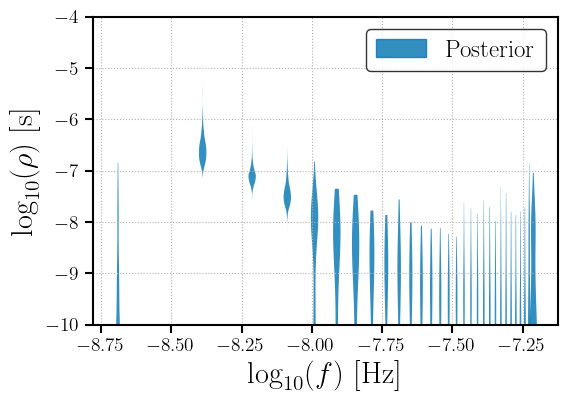

In [ ]:
plt.figure(figsize=(6, 4))
parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15])
for b in parts['bodies']:
    b.set_alpha(0.8)
# plt.plot(np.log10(freqs),  , '-o', lw=1)
# plt.plot(np.log10(freqs), injection, '-o', lw=1, label='Injected', zorder=-100)
plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
plt.xlabel("$\log_{10}(f)$ [Hz]")
plt.ylabel("$\log_{10}(\\rho)$ [s]")
plt.ylim(-10, -4)
plt.legend()
plt.savefig("../plots/single_pulsar_broken_powerlaw_injection_recovery.pdf")
plt.show()

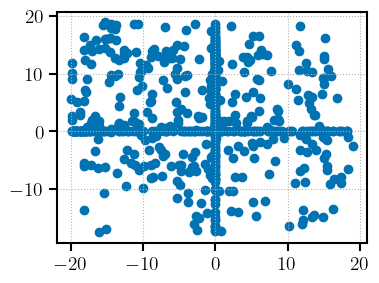

In [ ]:
plt.scatter(samples['beta_rn'][:, 9], samples['beta_rn'][:, 8])
# plt.scatter(, bins='auto')
plt.show()

(array([121.,  82.,  44.,  42.,  34.,  34.,  29.,  39.,  45.,  46.,  44.,
         47.,  51.,  51.,  50.,  49.,  38.,  33.,  48.,  73.]),
 array([0.01267411, 0.06190032, 0.11112653, 0.16035273, 0.20957894,
        0.25880515, 0.30803135, 0.35725756, 0.40648377, 0.45570997,
        0.50493618, 0.55416239, 0.60338859, 0.6526148 , 0.70184101,
        0.75106721, 0.80029342, 0.84951963, 0.89874583, 0.94797204,
        0.99719825]),
 <BarContainer object of 20 artists>)

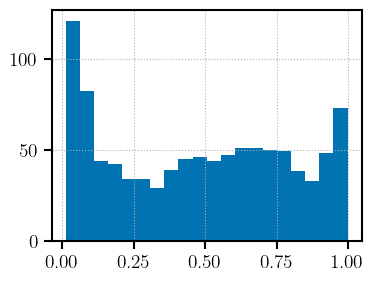

In [ ]:
plt.hist(samples['alpha_rn'], bins=20)

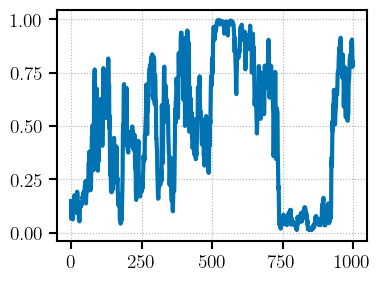

In [ ]:
plt.plot(samples['alpha_rn'])

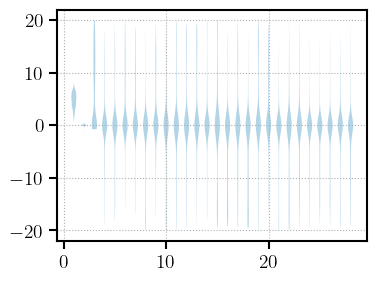

In [ ]:
plt.violinplot(samples['beta_rn'].squeeze(), showextrema=False)
plt.show()

In [129]:
fspec_model, gl = lncass_models.create_single_psr_freespec_model(psr, n_rn_freqs)
fspec_sampler = infer.MCMC(
    infer.NUTS(fspec_model, max_tree_depth=10),
    num_warmup=1000,
    num_samples=1000,
    num_chains=1,
    progress_bar=True,chain_method='vectorized'
)

In [130]:
with numpyro.validation_enabled():
    fspec_sampler.run(jax.random.PRNGKey(13))

sample: 100%|██████████| 2000/2000 [00:29<00:00, 67.95it/s, 63 steps of size 7.62e-02. acc. prob=0.91]


In [131]:
fspec_sampler.print_summary()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
 log10_rho[0]    -10.99      2.42    -10.98    -14.99     -7.71    599.71      1.00
 log10_rho[1]     -6.58      0.27     -6.63     -7.01     -6.19    556.31      1.00
 log10_rho[2]     -7.06      0.29     -7.10     -7.48     -6.66    452.35      1.00
 log10_rho[3]     -7.29      0.29     -7.31     -7.76     -6.85    738.63      1.00
 log10_rho[4]    -11.40      2.06    -11.46    -14.66     -8.32    422.56      1.00
 log10_rho[5]    -11.44      2.10    -11.44    -14.98     -8.46    299.17      1.01
 log10_rho[6]    -11.50      2.16    -11.57    -15.00     -8.48    413.37      1.00
 log10_rho[7]    -11.02      2.20    -11.03    -14.49     -7.72    638.04      1.00
 log10_rho[8]    -11.40      2.12    -11.37    -14.81     -8.35    462.41      1.00
 log10_rho[9]    -10.74      2.22    -10.59    -13.96     -7.25    463.48      1.00
log10_rho[10]    -11.58      2.09    -11.50    -14.99     -8.73    430.89  

In [132]:
fspec_samples = fspec_sampler.get_samples()

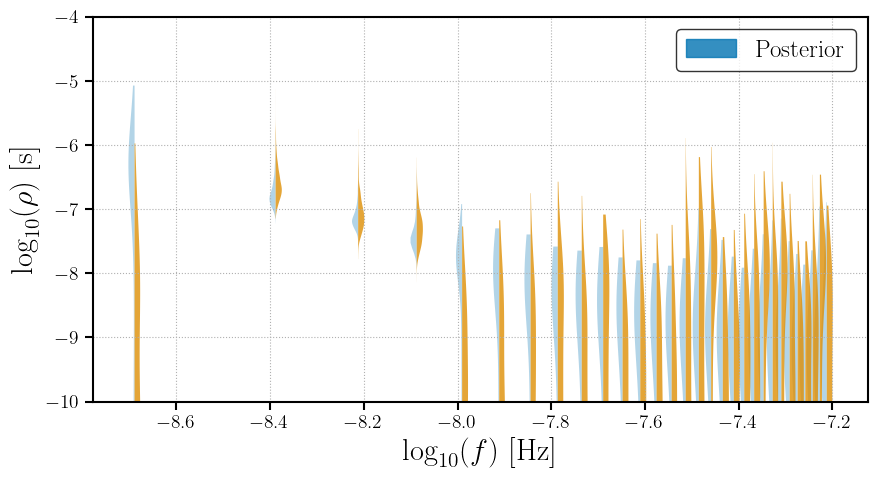

In [ ]:
plt.figure(figsize=(10, 5))
parts = plt.violinplot(samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15], side='low')
parts = plt.violinplot(fspec_samples['log10_rho'].squeeze(), showextrema=False, positions=np.log10(freqs), widths=np.diff(np.log10(freqs))[15], side='high')
for b in parts['bodies']:
    b.set_alpha(0.8)
# plt.plot(np.log10(freqs),  , '-o', lw=1)
# plt.plot(np.log10(freqs), injection, '-o', lw=1, label='Injected', zorder=-100)
plt.fill_between([], [], [], color='C0', alpha=0.8, label='Posterior')
plt.xlabel("$\log_{10}(f)$ [Hz]")
plt.ylabel("$\log_{10}(\\rho)$ [s]")
plt.ylim(-10, -4)
plt.legend()
plt.savefig("../plots/single_pulsar_broken_powerlaw_injection_recovery.pdf")
plt.show()

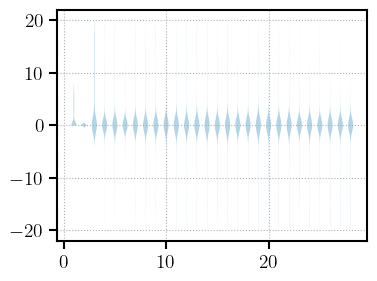

In [ ]:
plt.violinplot(samples['beta_rn'], showextrema=False)
plt.show()

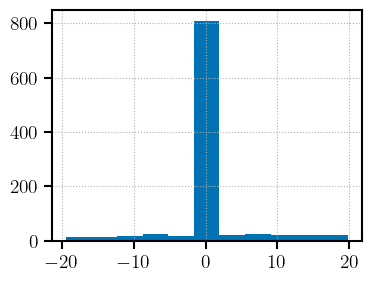

In [ ]:
plt.hist(samples['beta_rn'][:, 4], bins='auto')
plt.show()

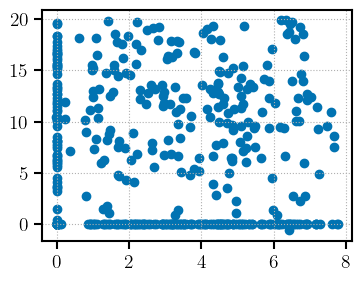

In [ ]:
plt.scatter(samples['beta_rn'][:, 0], samples['beta_rn'][:, 2])

(array([107.,  49.,  60.,  55.,  55.,  34.,  51.,  37.,  37.,  15.]),
 array([1.20739876e-04, 9.84703272e-02, 1.96819914e-01, 2.95169502e-01,
        3.93519089e-01, 4.91868676e-01, 5.90218264e-01, 6.88567851e-01,
        7.86917438e-01, 8.85267025e-01, 9.83616613e-01]),
 <BarContainer object of 10 artists>)

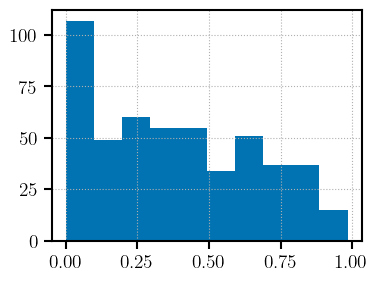

In [ ]:
plt.hist(samples['alpha_rn'], bins='auto')